<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageClassification_TensorFlow_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic MultiLabel Image Classification 

In this notebook we generate a very basic model in `tensorflow` to try to classify images of figure (from a **non public dataset**).

This notebook is an direct adaptation from the tensorflow basic tutorial notebook: [link](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=gN7G9GFmVrVY)


It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [56]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset

### Download data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
dataset_folderpath = "/content/input"

In [5]:
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [6]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [7]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz -C {dataset_folderpath}

clear_output()

!ls {dataset_folderpath}

raw  setup.py


### Split `train`, `val` and `test` dataset

The `zip` contains a script to generate the ml dataset

In [8]:
% cd {dataset_folderpath}
!python setup.py

/content/input
Number of classes : 20
['LineGraph', 'BubbleChart', 'BoxPlot', 'PersonPhoto', 'VennDiagram', 'NetworkDiagram', 'GeneralPhoto', 'ParetoChart', 'ScatterGraph', 'Table', 'GeneralFigure', 'TreeDiagram', 'Signatures', 'Map', 'RadarPlot', 'AreaGraph', 'PieChart', 'FlowChart', 'HorizontalBarGraph', 'VerticalBarGraph']
LineGraph: 
   > ntrain : 91
   > nval : 32
   > ntest : 7

BubbleChart: 
   > ntrain : 65
   > nval : 24
   > ntest : 5

BoxPlot: 
   > ntrain : 62
   > nval : 23
   > ntest : 5

PersonPhoto: 
   > ntrain : 75
   > nval : 27
   > ntest : 6

VennDiagram: 
   > ntrain : 100
   > nval : 36
   > ntest : 8

NetworkDiagram: 
   > ntrain : 67
   > nval : 25
   > ntest : 5

GeneralPhoto: 
   > ntrain : 43
   > nval : 15
   > ntest : 4

ParetoChart: 
   > ntrain : 65
   > nval : 24
   > ntest : 5

ScatterGraph: 
   > ntrain : 70
   > nval : 25
   > ntest : 5

Table: 
   > ntrain : 75
   > nval : 27
   > ntest : 6

GeneralFigure: 
   > ntrain : 111
   > nval : 40
   > ntes

In [9]:
input_folder = "/content/input/dataset"

trn_folder = os.path.join(input_folder,"train")
val_folder = os.path.join(input_folder,"val")
test_folder = os.path.join(input_folder,"test")

In [10]:
classes = [name for name in os.listdir(trn_folder) 
      if os.path.isdir(os.path.join(trn_folder,name))]
print(f"Number of classes : {len(classes)}")
print(classes)

Number of classes : 20
['LineGraph', 'BubbleChart', 'BoxPlot', 'PersonPhoto', 'VennDiagram', 'NetworkDiagram', 'GeneralPhoto', 'ParetoChart', 'ScatterGraph', 'Table', 'GeneralFigure', 'TreeDiagram', 'Signatures', 'Map', 'RadarPlot', 'AreaGraph', 'PieChart', 'FlowChart', 'HorizontalBarGraph', 'VerticalBarGraph']


In [11]:
# Output of script
total_test=140

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [13]:
batch_size = 8
epochs = 15
IMG_HEIGHT = 550
IMG_WIDTH = 550

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

 * `class_mode`: we want use a multi label classification (no binary). We should use `categorical`  which produces one-hot encoded class labels or `sparse` wich produce one int class label.

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=trn_folder,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 1839 images belonging to 20 classes.


In [16]:
total_train=1839

In [17]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_folder,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 661 images belonging to 20 classes.


In [18]:
total_val=661

### Visualize training images

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [19]:
sample_training_images, _ = next(train_data_gen)

In [20]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

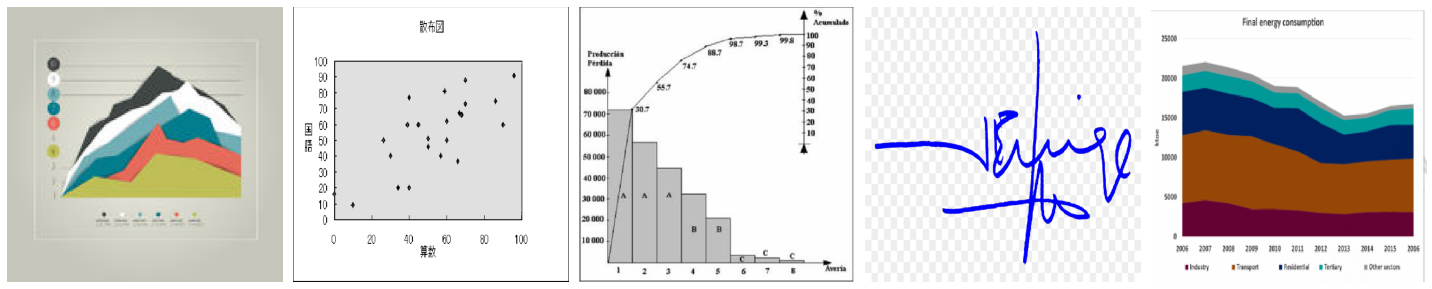

In [21]:
plotImages(sample_training_images[:5])

In [22]:
def get_cls_path_distribution(classes, dataset_folderpath):
  cls_examples = {}
  for cls in classes:
    cls_folder = os.path.join(dataset_folderpath, cls)
    cls_examples[cls] = len([name for name in os.listdir(cls_folder) 
                            if os.path.isfile(os.path.join(cls_folder,name))])
  cls_examples = {k: v for k, v in sorted(cls_examples.items(), key=lambda item: item[1], reverse=True)}
  return cls_examples

def print_cls_path_distribution(classes, dataset_folderpath):
  cls_examples = get_cls_path_distribution(classes, dataset_folderpath)

  print(f"Examples per class : {sum(cls_examples.values())}")
  for cls in cls_examples:
    print(f"\t- {cls} = {cls_examples[cls]}")

print_cls_path_distribution(classes, trn_folder)

Examples per class : 1839
	- VerticalBarGraph = 251
	- PieChart = 137
	- Map = 116
	- HorizontalBarGraph = 112
	- GeneralFigure = 111
	- VennDiagram = 100
	- AreaGraph = 95
	- LineGraph = 91
	- TreeDiagram = 83
	- FlowChart = 77
	- PersonPhoto = 75
	- Table = 75
	- Signatures = 72
	- RadarPlot = 72
	- ScatterGraph = 70
	- NetworkDiagram = 67
	- BubbleChart = 65
	- ParetoChart = 65
	- BoxPlot = 62
	- GeneralPhoto = 43


## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

The final layer should contain the number of nodes as the number of labels of our classes. We use `sigmoid` to obtain a output probability by class.

In [23]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(classes), activation='sigmoid')
])

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *categorical cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

Your code needs to be consistent, in your `flow_from_generator` calls you set class mode to `categorical`, which produces one-hot encoded class labels, you should use `categorical_crossentropy`. Or if you set class mode to `sparse`, which produces a integer label, you should use `sparse_categorical_crossentropy`. [link](https://stackoverflow.com/questions/54232549/multi-class-and-variable-size-image-classification-with-flow-from-directory)

In [24]:
model.compile(
    optimizer='adam',
    loss=['categorical_crossentropy'],
    metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 550, 550, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 275, 275, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 275, 275, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 137, 137, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 137, 137, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 68, 68, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 295936)            0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [26]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 31/229 [===>..........................] - ETA: 28s - loss: 3.8559 - accuracy: 0.1008

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


229/229 [==============================] - 47s 205ms/step - loss: 2.8693 - accuracy: 0.1300 - val_loss: 2.6300 - val_accuracy: 0.1479
Epoch 2/15
229/229 [==============================] - 46s 202ms/step - loss: 2.1010 - accuracy: 0.2933 - val_loss: 2.3617 - val_accuracy: 0.3064
Epoch 3/15
229/229 [==============================] - 46s 201ms/step - loss: 1.0573 - accuracy: 0.6985 - val_loss: 2.9181 - val_accuracy: 0.4101
Epoch 4/15
229/229 [==============================] - 46s 201ms/step - loss: 0.3025 - accuracy: 0.9197 - val_loss: 4.0344 - val_accuracy: 0.3537
Epoch 5/15
229/229 [==============================] - 46s 201ms/step - loss: 0.1844 - accuracy: 0.9503 - val_loss: 4.2838 - val_accuracy: 0.3750
Epoch 6/15
229/229 [==============================] - 46s 200ms/step - loss: 0.1222 - accuracy: 0.9672 - val_loss: 3.8282 - val_accuracy: 0.3277
Epoch 7/15
229/229 [==============================] - 46s 201ms/step - loss: 0.1232 - accuracy: 0.9705 - val_loss: 4.7942 - val_accuracy: 0.3

### Visualize training results

Now visualize the results after training the network.

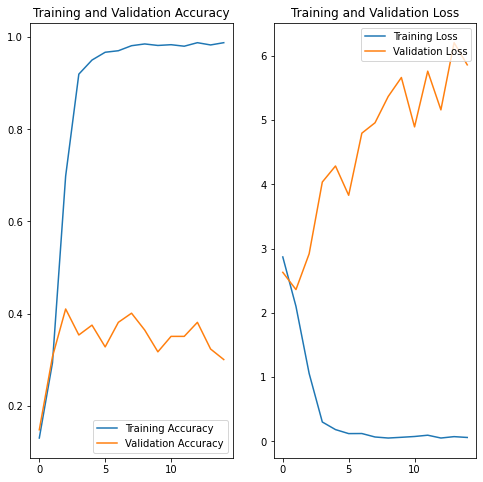

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [28]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [29]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=trn_folder,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1839 images belonging to 20 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [30]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

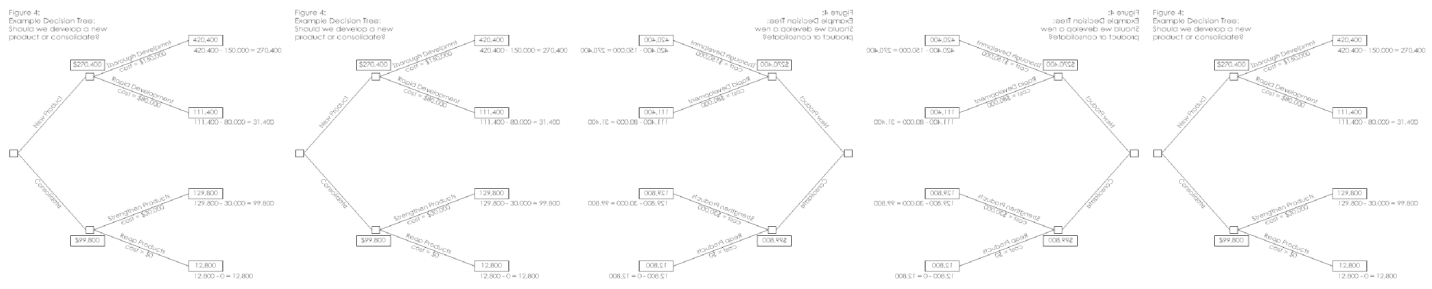

In [31]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [32]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [33]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=trn_folder,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1839 images belonging to 20 classes.


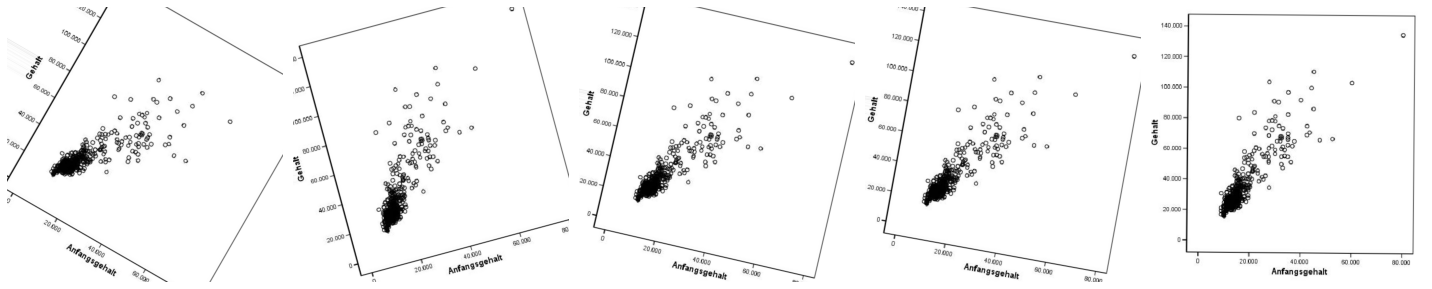

In [34]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [35]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [36]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=trn_folder,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1839 images belonging to 20 classes.


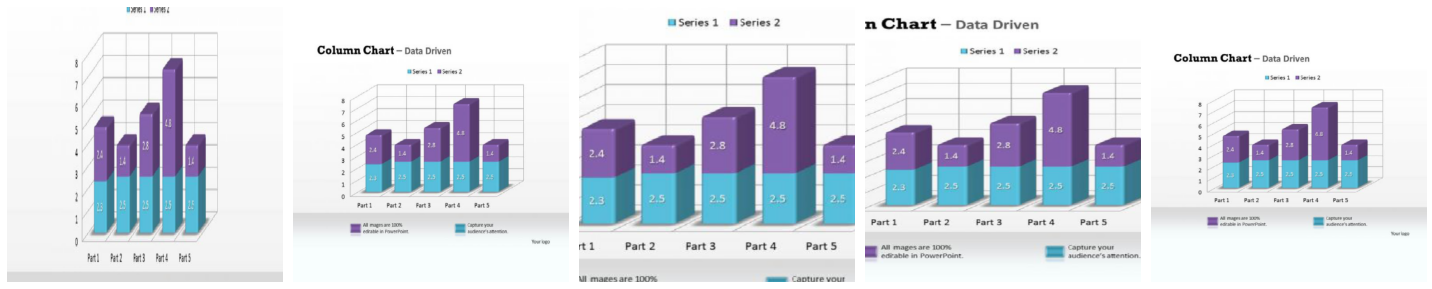

In [37]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [49]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [50]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=trn_folder,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1839 images belonging to 20 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

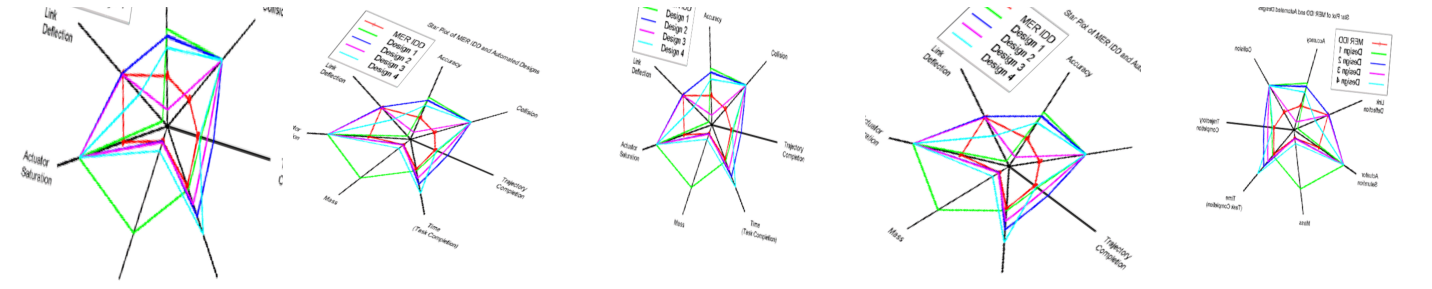

In [40]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [47]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [48]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_folder,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 661 images belonging to 20 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

In [51]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(classes), activation='sigmoid')
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [55]:
model_new.compile(
    optimizer='adam',
    loss=['categorical_crossentropy'],
    metrics=['accuracy'])

model_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 550, 550, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 275, 275, 16)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 275, 275, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 275, 275, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 137, 137, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 137, 137, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 68, 68, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [53]:
epochs = 15

In [54]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
 37/229 [===>..........................] - ETA: 2:05 - loss: 9.3234 - accuracy: 0.0712

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 43/229 [====>.........................] - ETA: 2:00 - loss: 9.4892 - accuracy: 0.0612

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


229/229 [==============================] - 163s 712ms/step - loss: 4.4455 - accuracy: 0.1081 - val_loss: 2.9349 - val_accuracy: 0.1372
Epoch 2/15
229/229 [==============================] - 166s 725ms/step - loss: 2.9505 - accuracy: 0.1360 - val_loss: 2.9300 - val_accuracy: 0.1372
Epoch 3/15
229/229 [==============================] - 165s 721ms/step - loss: 2.9318 - accuracy: 0.1365 - val_loss: 2.9186 - val_accuracy: 0.1372
Epoch 4/15
229/229 [==============================] - 162s 706ms/step - loss: 2.9321 - accuracy: 0.1360 - val_loss: 2.9157 - val_accuracy: 0.1372
Epoch 5/15
229/229 [==============================] - 158s 690ms/step - loss: 2.9163 - accuracy: 0.1365 - val_loss: 2.9170 - val_accuracy: 0.1387
Epoch 6/15
229/229 [==============================] - 157s 685ms/step - loss: 2.9100 - accuracy: 0.1365 - val_loss: 2.9195 - val_accuracy: 0.1372
Epoch 7/15
229/229 [==============================] - 156s 682ms/step - loss: 2.9052 - accuracy: 0.1354 - val_loss: 2.9253 - val_accura

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

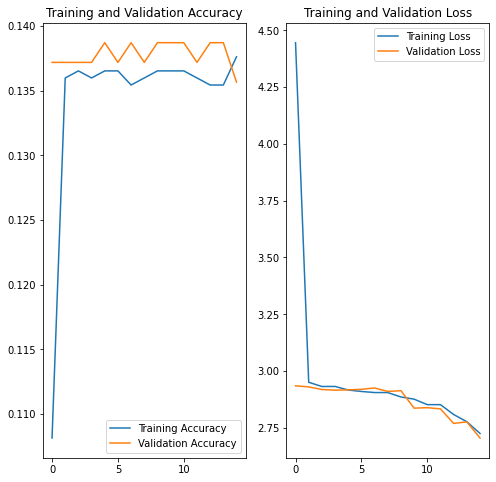

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()